In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [8]:
import os
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta as td
from models.lstm import LSTMAutoencoder, LSTMAutoencoderParams
from models.common import HyperParams

import unittest
import numpy as np
from numpy import testing
import pandas as pd
from preprocessing.test_common import make_labels, make_series
from preprocessing.helper import TimeseriesHelper
from preprocessing.preprocessing import TimeSeriesPreprocessor
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [4]:
os.chdir(os.getcwd())
os.chdir('..')
print(os.getcwd())

/Users/konst/stackvista/time-series/notebooks
/Users/konst/stackvista/time-series


In [21]:
helper = TimeseriesHelper()

data_frame = helper.load_labeled_series("realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv")
# data_frame = helper.load_labeled_series("realKnownCause/ec2_request_latency_system_failure.csv")
data_frame[data_frame['label'] != 0]

,timestamp,y,label


Empty DataFrame
Columns: [timestamp, y, label]
Index: []
timestamp
y
label


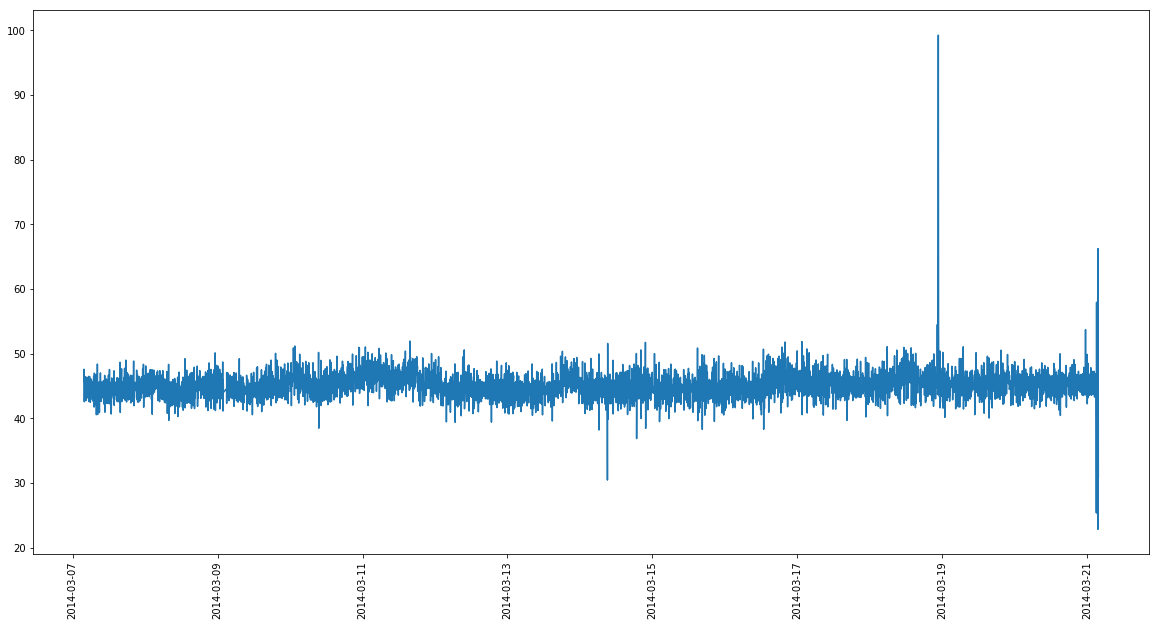

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(data_frame['timestamp'], data_frame['y'])
plt.xticks(rotation='vertical')
discords = data_frame[data_frame['label']==1]
print(discords)
for discord in data_frame[data_frame['label']==1]:
    print(discord)
#     plt.axvspan(discord['timestamp'].value, discord['timestamp'].value, alpha=0.5, color='red')


In [23]:
input_variables = ['y', 'label']
output_variables = ['y', 'label']

preprocessor = TimeSeriesPreprocessor(
    window_size_seconds = 7200,
    window_shift = 3600,
    horizon_shift_seconds = 3600,
    probe_period_seconds = 300)

windows = preprocessor.make_dataset_from_series_and_labels(data_frame,
        input_vars = input_variables, output_vars = output_variables,
        numeric_vars = ["y"], auto_impute= ["y", 'label'])

input = np.stack([w[0].to_numpy() for w in windows])
output = np.stack([w[1].to_numpy() for w in windows])

n_in_features = len(input_variables)
n_out_features = len(output_variables)
timesteps_back = input.shape[1]
timesteps_forward = output.shape[1]
seed = 42
epoch_count = 10
learning_rate = 0.0005
batch_size = 128
train_test_split_ratio = 0.2
train_valid_split_ratio = 0.3

X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=train_test_split_ratio, random_state = seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=train_valid_split_ratio, random_state = seed)

lstm_params = LSTMAutoencoderParams(timesteps_back = timesteps_back, timesteps_forward = timesteps_forward,
        n_in_features = n_in_features, n_out_features = n_out_features, seed = seed)
hyper_params = HyperParams(epoch_count = epoch_count, learning_rate = learning_rate, batch_size = batch_size)
lstm = LSTMAutoencoder(lstm_params = lstm_params, hyper_params = hyper_params)
lstm.fit(X_train, y_train, X_valid, y_valid)

Y_pred = lstm.predict(X_test)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 24)            2592      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 16)            2624      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 72        
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 1)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
lstm_5 (LSTM)                (None, 12, 16)            1856      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 2)             34        
Total para